
EE4414 Team Practice
==============================================

In this team practice, you will design Convolutional Neural Network(s) to classify food images.




In [1]:
!pip install datasets
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 6.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [2]:
%matplotlib inline

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets.folder import make_dataset
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy


plt.ion()   # interactive mode

## 1. Loading data

Define the dataset, dataloader, and the data augmentation pipeline.

The code below loads 5 classes from all 12 classes in the dataset. You need to modify it to load only the classes that you need.

***Note: For correctly assessing your code, do not change the file structure of the dataset. Use Pytorch data loading utility (`torch.utils.data`) for customizing your dataset.***

In [4]:
!gdown 1ehiWl_n1aymnfBTK6IUiqXA5bqn9mqyy

Downloading...
From (original): https://drive.google.com/uc?id=1ehiWl_n1aymnfBTK6IUiqXA5bqn9mqyy
From (redirected): https://drive.google.com/uc?id=1ehiWl_n1aymnfBTK6IUiqXA5bqn9mqyy&confirm=t&uuid=30bd6e73-023d-4759-bf33-e2b8dc08de86
To: /content/sg_food.zip
100% 323M/323M [00:01<00:00, 165MB/s]


In [5]:
import os
import zipfile


zip_ref = zipfile.ZipFile("/content/sg_food.zip", 'r')
zip_ref.extractall("/content/data")
zip_ref.close()

os.remove("/content/sg_food.zip")

In [6]:
# Define the dataset class
class sg_food_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        self.classes = [all_classes[x] for x in class_id]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


In [7]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        # Define data preparation operations for training set here.
        # Tips: Use torchvision.transforms
        #       https://pytorch.org/vision/stable/transforms.html
        #       Normally this should at least contain resizing (Resize) and data format converting (ToTensor).
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'val': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
}

data_dir = os.path.join('data', 'sg_food')
subfolder = {'train': 'train', 'val': 'val'}

# Define the dataset
selected_classes = [0, 2, 3, 7, 8, 9]
n_classes = len(selected_classes)
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x])
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [0, 2, 3, 7, 8, 9]
    name: ['Bak Chor Mee', 'Chicken Rice', 'Hokkien Prawn Mee', 'Oyster Omelette', 'Roast Meat Rice', 'Roti Prata']


## 2. Visualizing the dataset
Fetch a batch of training data from the dataset and visualize them.



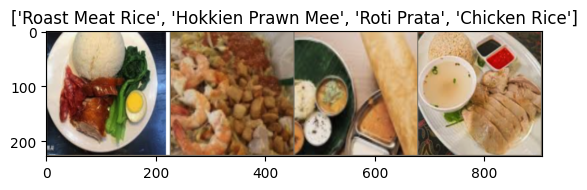

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

In [9]:
from datasets import load_dataset


dataset = load_dataset("data", data_dir="sg_food")
dataset

Resolving data files:   0%|          | 0/1200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/360 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2400 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1200
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 360
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2400
    })
})

In [10]:
dataset['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=145x182>,
 'label': 0}

In [11]:
train_ds = dataset['train']
val_ds = dataset['validation']
test_ds = dataset['test']

In [12]:
from transformers import ViTImageProcessor

model_name = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [13]:
def train_transforms(examples):
    examples['pixel_values'] = [data_transforms['train'](image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [data_transforms['val'](image.convert("RGB")) for image in examples['image']]
    return examples

In [14]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [15]:
train_ds[0:2]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=145x182>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=270x180>],
 'label': [0, 0],
 'pixel_values': [tensor([[[ 0.1254,  0.1254,  0.0227,  ..., -0.8678, -0.8507, -0.8507],
           [ 0.1254,  0.1254,  0.0227,  ..., -0.8678, -0.8507, -0.8507],
           [ 0.2796,  0.2796,  0.1768,  ..., -0.8849, -0.8678, -0.8678],
           ...,
           [-0.7308, -0.7308, -0.6965,  ...,  0.8104,  0.7591,  0.7591],
           [-0.8849, -0.8849, -0.9020,  ...,  0.7248,  0.6734,  0.6734],
           [-0.8849, -0.8849, -0.9020,  ...,  0.7248,  0.6734,  0.6734]],
  
          [[-0.4951, -0.4951, -0.5826,  ..., -1.8431, -1.8256, -1.8256],
           [-0.4951, -0.4951, -0.5826,  ..., -1.8431, -1.8256, -1.8256],
           [-0.3200, -0.3200, -0.4076,  ..., -1.8606, -1.8431, -1.8431],
           ...,
           [-1.1429, -1.1429, -1.1779,  ..., -0.9153, -0.9328, -0.9328],
           [-1.0728, -1.0728, -1.1429,  ..., -0.8102, -0.8

In [16]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [17]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-17-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [18]:
from transformers import ViTForImageClassification

labels = dataset['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./vit-base-sg-food",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    num_train_epochs=10,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [20]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=processor,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [21]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
1,2.257700,1.432518,0.819444
2,1.283400,0.865529,0.883333
3,0.820600,0.624930,0.911111
4,0.543800,0.524679,0.900000
5,0.408200,0.467216,0.913889
6,0.337500,0.419659,0.902778
7,0.278300,0.415516,0.902778
8,0.293600,0.389553,0.900000
9,0.232300,0.364673,0.916667
10,0.209000,0.361716,0.919444


***** train metrics *****
  epoch                    =        10.0
  total_flos               = 866118091GF
  train_loss               =      0.6304
  train_runtime            =  0:04:23.65
  train_samples_per_second =      45.513
  train_steps_per_second   =       0.721


In [22]:
metrics = trainer.evaluate(val_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9194
  eval_loss               =     0.3617
  eval_runtime            = 0:00:03.10
  eval_samples_per_second =    115.843
  eval_steps_per_second   =      1.931


In [23]:
outputs = trainer.predict(test_ds)
trainer.log_metrics("test", outputs.metrics)
trainer.save_metrics("test", outputs.metrics)

***** test metrics *****
  test_accuracy           =     0.9096
  test_loss               =     0.3884
  test_runtime            = 0:00:21.50
  test_samples_per_second =    111.621
  test_steps_per_second   =      1.767


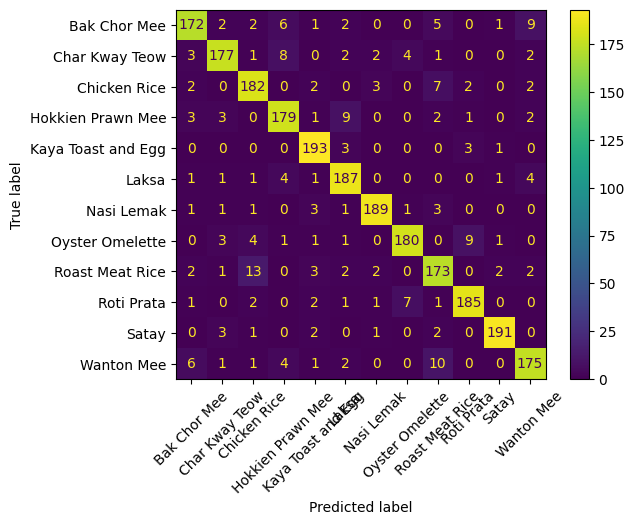

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

## 3. Defining function to train the model

Use a pre-trained CNN model with transfer learning techniques to classify the 5 food categories.

(Note: The provided code is only for reference. You can modify the code whichever way you want.)


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    train_loader = dataloaders['train']
    valid_loader = dataloaders['val']

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        valid_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.logits, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {accuracy:.4f}")

        scheduler.step(valid_loss)

    return model

## 4. Training and validating the model

Train your model for minimum 3 epochs.

### 4.1 Loading pretrained model and defining new classfier layer


In [ ]:
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification

# (code)

# 2. Modify the pretrain model for your task.

# (code)

# 3. Choose your loss function, optimizer, etc.

# (code)


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import ViTForImageClassification


model_name = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(model_name)
model = model.to(device)

num_classes = len(image_datasets['train'].classes)
model.classifier = nn.Linear(model.config.hidden_size, num_classes)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### 4.2 Printing and visualizing the modified model

In [ ]:
print(model)

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

### 4.3 Training using train data and evaluating using validation data

Train your model for minimum 3 epochs.

In [ ]:
# TODO
# model_resnet18 = train_model(...)

In [ ]:
vit_model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10)

## 5. Loading test data

Define the dataset and dataloader for testing.

In [ ]:
test_dir = os.path.join('data', 'sg_food', 'test')

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)

# Define the dataloader for testing.
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

## 6. Visualizing the predictions

Predict the label on a few testing samples and visualize the results.

In [ ]:
# TODO

# num_images = 4

# (code)

# with torch.no_grad():
    # Predict on the test set

    # (code)

    # Print the output images and labels

    # (code)


In [ ]:
num_images = 4
inputs, classes = next(iter(test_loader))

with torch.no_grad():
    outputs = vit_model(inputs[:num_images])
    _, predicted = torch.max(outputs.logits, 1)

out = torchvision.utils.make_grid(outputs)
imshow(out, title=[class_names[x] for x in predicted])

## 7. Evaluating on test set

Evaluate your model on the whole test set and compute the accuracy.

In [ ]:
vit_model.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = vit_model(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))
